In [1]:
import numpy as np
import pydub
import matplotlib.pyplot as plt
import sys
import time

In [2]:
path = "./songs/epic_part_beginning.wav"
sound = pydub.AudioSegment.from_file(path, format="wav", frame_rate=44100, channels=1, sample_width=1)

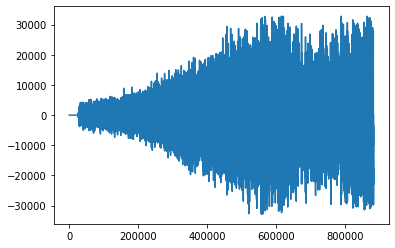

882000


In [3]:
plot_1sec = sound[:10000].get_array_of_samples()
plt.plot(plot_1sec)
plt.show()
print(len(sound[:10000].get_array_of_samples()))

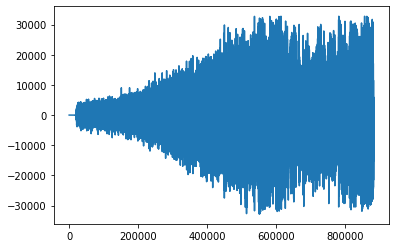

882000


In [4]:
original = pydub.AudioSegment.from_file("./songs/epic.wav", format="wav", frame_rate=44100, channels=1, sample_width=1)
plot_1sec = original[:10000].get_array_of_samples()
plt.plot(plot_1sec)
plt.show()

print(len(original[:10000].get_array_of_samples()))

In [5]:
# song = [[]] * 6
# for i in range(6):
#     song[i] = [e for e in original[i*10000:(i+1)*10000].get_array_of_samples()]
# song = np.array(song)
start = time.time()
song = np.array(original.get_array_of_samples())
part = np.array(sound.get_array_of_samples())
# song = np.asarray(list(original.raw_data))
# part = np.asarray(list(sound.raw_data))
# print(type(song))

In [6]:
def sample(song, chunk_size):
    size = len(song)
    sampled_chunk_size = int(size/chunk_size)

    sampled = np.zeros(shape=(sampled_chunk_size, chunk_size), dtype=np.complex_)

    for i in range(sampled_chunk_size):
        time_variations = np.zeros(chunk_size, dtype=np.complex_)

        for j in range(chunk_size):
            time_variations[j] = complex(song[i * chunk_size + j], 0)

    #     print(time_variations)
        sampled[i] = np.fft.fft(time_variations)
    #     print(sampled[i])
    # plt.plot(sampled)
    # plt.show()
    
    return sampled

In [7]:
# for i in sampled[:100]:
#     for j in i:
#         if j.real != 0:
#             print(abs(j.real))

In [8]:
FREQUENCIES = [40, 80, 120, 180, 300]

def get_range_of_frequency(frq):
    return max(list(range(len(FREQUENCIES))), key = lambda x: FREQUENCIES[x] > frq)

In [9]:
def get_fuzzed(peak, fuzz):
    return np.int64(peak - (peak%fuzz))

In [10]:
def fingerprint_hash(peaks):
    fuzz_factor = 2
    i = 1
    fingerprint = np.int64(0)
    
    for p in peaks:
        fingerprint+=get_fuzzed(p, fuzz_factor) * i
        i*=1000
#     print("fingerprint", fingerprint.astype(np.int64))
    return fingerprint

In [11]:
def point_position(number, pos=2): #pos=2 -> 3 digit number
    while(number < 10**pos):
        number*=10
    num = number.astype(np.int64)
#     print("number: ", num)
    return num

In [12]:
def fingerprint(sampled):
    peaks = np.zeros(shape=(sampled.shape[0], len(FREQUENCIES)-1), dtype=np.int64)
    values = np.zeros(shape=(sampled.shape[0], len(FREQUENCIES)), dtype=np.int64)

    highest = np.zeros(shape=(sampled.shape[0], len(FREQUENCIES)), dtype=np.float64)
    
    hashed = np.zeros(shape=sampled.shape[0], dtype=np.int64)
    unique = []
    
    for i in range(0, sampled.shape[0]):
        for frq in range(40, 300):
            magnitude = np.log(np.abs(sampled[i][frq])+1)
    #         if magnitude != 0:
    #             print(np.log2(np.abs(sampled[i][frq])+1))
            range_index = get_range_of_frequency(frq)
    #         print("magnitude: ", magnitude)
    #         print("highest: ", highest[i][range_index])

    #         print(highest[i][range_index])
    #         if magnitude > highest[i][range_index]:
    #             highest[i][range_index] = frq
    #             values[i][range_index] = magnitude
    #             peaks[i][range_index] = point_position(magnitude)

            if magnitude > highest[i][range_index]:
                highest[i][range_index] = magnitude
                values[i][range_index] = frq
                peaks[i][range_index-1] = frq

        hashed[i] = fingerprint_hash(peaks[i])
        unique.append(tuple(values[i]))
    
    return hashed, unique

In [13]:
sampled = sample(part, 512)
sampled_full = sample(song, 512)

# for i in len(song):
# print(sampled[:20])

In [14]:
hashed, unique = fingerprint(sampled)
hashed_full, unique_full = fingerprint(sampled_full)

Fingerprinting 2 songs... 149.77
unique full: 11989 unique:  1086 hashed song:  34691 hashed part:  1682


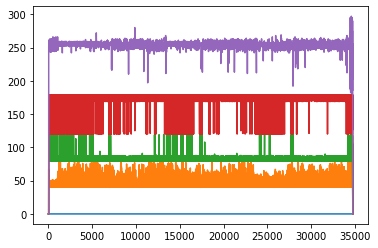

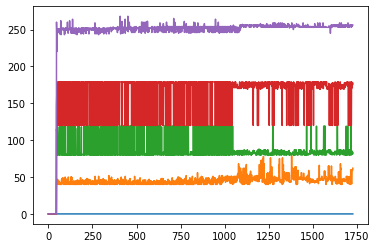

260146114042
250158112042
220166118040
244178098042
250178116044
248178108044
250128080046
250176082044
248120080042
250120080044
248120080040
246120080042
250120080044
250178080040
248120080042
250178080040
250178118042
248178080042
244178080042
244120080040


In [15]:
hashed = np.trim_zeros(hashed)
hashed_full = np.trim_zeros(hashed_full)
end = time.time()

print(f'Fingerprinting 2 songs... {end - start:.2f}')

# plt.hist(hashed)
print("unique full:", len(list(set(unique_full))), "unique: ", len(list(set(unique))), "hashed song: ", len(hashed_full), "hashed part: ", len(hashed))
plt.plot(unique_full)
plt.show()

plt.plot(unique)
plt.show()
# print(unique)
# print("hashed:", len(hashed[:100]))
for i in hashed[:20]:
    print(i)

In [16]:
for i in hashed_full[:20]:
    print(i)

252174084046
252178080066
250178106040
248176080040
250170080040
250176114040
250170116042
244120080040
248178080042
250178080042
248178080040
250178118042
250178080044
250178080044
248178118040
260120080044
250178080040
250120080042
244178080040
260178118042


In [17]:
matching = 0
for i, e in enumerate(hashed_full):
    if i > len(hashed):
        break
    if e in hashed[i:]:
        matching+=1
print(matching)

1090


In [18]:
current_index = 0
count = 0
epsilon = 1174106058
max_diff = epsilon * 2
prev = hashed[1]
size = len(hashed)

for i in range(size):
    difference = np.abs(hashed[i]-hashed_full[current_index])
    prev_difference = np.abs(hashed[i]-hashed_full[current_index-1])
    if difference < epsilon:
        current_index+=1
        count+=1
    if difference > max_diff:
        if prev_difference < epsilon:
            current_index-=2
            count+=1
        current_index+=1
        prev = hashed[i]
        
    if np.abs(prev-hashed[current_index]) < epsilon:
        count+=1
        
print(count)
print(matching + count)

779
1869


In [19]:
epsilon = 1174106058
count = 0
full_index = 0
i = 2
while i < len(hashed):
    if full_index > len(hashed_full):
        break
    prev_h = hashed[i-2]
    current_h = hashed[i-1]
    next_h = hashed[i]
#     print("current:", current_h, "index: ", i, ":", full_index)
    if np.abs(prev_h - hashed_full[full_index]) <= epsilon:
        matched = full_index
        full_index+=1
        count+=1
#         print(prev_h, " - ", hashed_full[full_index-1])
    elif full_index > i and full_index-(i-2) > 2:
        i = full_index
    else:
        if np.abs(next_h - hashed_full[full_index]) <= epsilon:
            if np.abs(prev_h - hashed_full[full_index+1]) <= epsilon:
                full_index+=1
                i-=1
            elif np.abs(current_h - hashed_full[full_index+1]) <= epsilon:
                full_index+=1
            else:
                i+=1
        elif np.abs(current_h - hashed_full[full_index]) <= epsilon:
            i+=1
            continue
        else:
            full_index+=1
            i-=1
    i+=1
print(count)

1060


In [20]:
epsilon = 1174106058
count = 0
i = 2

for j in range(len(hashed_full)):
    if len(hashed_full) - j < len(hashed):
        break
    maximum = 0
    full_index = j
    while i < len(hashed):    
        prev_h = hashed[i-2]
        current_h = hashed[i-1]
        next_h = hashed[i]
    #     print("current:", current_h, "index: ", i, ":", full_index)
        if np.abs(prev_h - hashed_full[full_index]) <= epsilon:
            matched = full_index
            full_index+=1
            maximum+=1
    #         print(prev_h, " - ", hashed_full[full_index-1])
        elif full_index > i and full_index-(i-2) > 2:
            i = full_index
        else:
            if np.abs(next_h - hashed_full[full_index]) <= epsilon:
                if np.abs(prev_h - hashed_full[full_index+1]) <= epsilon:
                    full_index+=1
                    i-=1
                elif np.abs(current_h - hashed_full[full_index+1]) <= epsilon:
                    full_index+=1
                else:
                    i+=1
            elif np.abs(current_h - hashed_full[full_index]) <= epsilon:
                i+=1
                continue
            else:
                full_index+=1
                i-=1
        i+=1
#     print(maximum)
    if maximum > count:
        count = maximum
print(count)

1060


In [21]:
start = time.time()

count = 0
epsilon = 26000000
for i in range(len(hashed_full) - len(hashed)):
    max_ = 0
    for j in range(len(hashed)):
        if np.abs(hashed[j]-hashed_full[i+j]) <= epsilon:
            max_+=1
    if max_ > count:
        count = max_
        if count >= len(hashed)/2:
            break
            
end = time.time()
print(count)
print(f'slow: elapsed: {end - start:.2f}')

526
slow: elapsed: 199.39


In [27]:
start = time.time()

count = 0
epsilon = 26000000
i = 0

while i < len(hashed_full) - len(hashed):
    max_ = 0
    for j in range(len(hashed)):
        if np.abs(hashed[j]-hashed_full[i+j]) <= epsilon:
            max_+=1
    if max_ > count:
        count = max_
        if count >= len(hashed)/2:
            break
    i += 1
            
end = time.time()
print(count)
print(f'Matchmaking: {end - start:.2f}')

526
Matchmaking: 84.62


In [29]:
valid = (count + matching)*100/len(hashed)
print(valid)
if valid > 45:
    print("matched")
else:
    print("not matching")

31.27229488703924
not matching


In [24]:
arr1 = hashed 
arr2 = hashed_full

def lcs(arr1, arr2):
    mem = [[0 for col in range(len(arr2))] for row in range(len(arr1))]
    
    for i in range(len(arr1)):
        for j in range(len(arr2)):
            if i == 0 or j == 0:
                mem[i][j] = 0
            elif np.abs(arr1[i]-arr2[j]) <= epsilon:
            #elif arr1[i] == arr2[j]:
                mem[i][j] = mem[i - 1][j - 1] + 1
            else:
                mem[i][j] = max(mem[i][j - 1], mem[i - 1][j])
    
    return mem

start = time.time()
mem = lcs(arr2, arr1)
end = time.time()
print(f'faster pls: elapsed: {end - start:.2f}')
#for row in mem:
#    print(row)
print(mem[len(arr2) - 1][len(arr1) - 1])



faster pls: elapsed: 258.95
1680


In [25]:
arr2 = np.zeros(shape=(4441))
arr1 = np.zeros(shape=(221))

start = time.time()
mem = lcs(arr2, arr1)
end = time.time()
print(f'faster pls: elapsed: {end - start:.2f}')
#for row in mem:
#    print(row)
print(mem[len(arr2) - 1][len(arr1) - 1])

faster pls: elapsed: 5.32
220


In [26]:
# f= open("hashed_song.txt","w+")

# for i in hashed_full:
#      f.write(f"{i}\n")
        
# f.close() 